In [80]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}

stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [82]:
events = parse("/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
events = next(events)[0]
n_events = 312
events_to_analyze = events[events.event < n_events]

In [83]:
events_to_analyze

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0
0,0,-80.90526,-10.274100,-145.164000,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,-75.78151,-30.139360,-36.078560,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,-75.78151,-30.139360,259.800600,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,70.23064,-41.459310,-249.458300,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,-124.69720,-18.451980,-211.953700,1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
14947,311,118.91890,-41.811080,-238.796800,1,23,0.237803,-0.102587,-0.500582,0.838779,-0.231903,-1.184486
14948,311,158.23000,-51.998400,-317.999400,2,23,0.237803,-0.102587,-0.500582,0.838779,-0.231903,-1.184486
14949,311,81.24136,7.145566,0.349709,0,26,0.318604,0.052094,0.057076,0.838779,-0.231903,-1.184486
14950,311,125.61850,10.481710,8.307509,1,26,0.318604,0.052094,0.057076,0.838779,-0.231903,-1.184486


In [84]:
!ls /zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2

last	    version_13	version_19  version_24	version_3   version_6
version_0   version_14	version_2   version_25	version_30  version_7
version_1   version_15	version_20  version_26	version_31  version_8
version_10  version_16	version_21  version_27	version_32  version_9
version_11  version_17	version_22  version_28	version_4
version_12  version_18	version_23  version_29	version_5


In [85]:
import torch

tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2', 
                           'version': 'version_22', 'checkpoint': 'latest'}
classifier_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
                             'version': 'version_108', 'checkpoint': 'latest'}
input_dir='/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/output/cgem_t_plain_valid_gov_test'
file_mask = 'tracknet_599.npz'
last_station_file_mask='tracknet_599_last_station.npz'
use_classifier=True
draw_figures=True
max_num_events=200
treshold_min=0.35
treshold_max=0.9
treshold_step=0.05

threshold=0.5

tracknet_input_features=3
tracknet_conv_features=32

_constraints = {'r': [80., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}
_columns=('r', 'phi', 'z')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
from ariadne.utils import get_checkpoint_path, weights_update
from ariadne.tracknet_v2.model import TrackNETv2
from ariadne.tracknet_v2_1.model import TrackNetClassifier

In [87]:
path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)
path_to_classifier_ckpt = get_checkpoint_path(**classifier_ckpt_path_dict)

model = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
model.eval()

TrackNETv2(
  (conv): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): GRU(32, 32, num_layers=2, batch_first=True)
  (xy_coords): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
  (r1_r2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [88]:
model.to(DEVICE)
class_model = weights_update(model=TrackNetClassifier(coord_size=2),
                             checkpoint=torch.load(path_to_classifier_ckpt, map_location=torch.device(DEVICE)))
class_model.to(DEVICE)

TrackNetClassifier(
  (gru_feat_block): Sequential(
    (0): Linear(in_features=32, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=True)
  )
  (coord_feat_block): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [89]:
from ariadne.utils import load_data, store_in_index,search_in_index
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df


from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort

In [90]:
events = load_data(input_dir, file_mask, None)
all_last_station_coordinates = load_data(input_dir, last_station_file_mask, None)

[[-0.03212956 -0.12680989 -0.96425285]
 [-0.11586902  0.51660818  0.05873527]]
[-2. -2.]
2
[nan nan nan]
False
0
[0.28954144 0.50203806]
0


In [91]:
import itertools

def get_seeds(hits, columns=['x','y','z']):
    temp1 = hits[hits.station == 0]
    st0_hits = hits[hits.station == 0][columns].values
    temp2 = hits[hits.station == 1]
    st1_hits = hits[hits.station == 1][columns].values
    # all possible combinations
    idx0 = range(len(st0_hits))
    idx1 = range(len(st1_hits))
    idx_comb = itertools.product(idx0, idx1)
    # unpack indices
    idx0, idx1 = zip(*idx_comb)
    idx0 = list(idx0)
    idx1 = list(idx1)
    # create seeds array
    seeds = np.zeros((len(idx0), 2, 3))
    seeds[:, 0, ] = st0_hits[idx0]
    seeds[:, 1, ] = st1_hits[idx1]
    return seeds

In [92]:
NUM_COMPONENTS = 2
SUFX = ['_p', '_c']
COLS = ['z', 'phi']

transformer = Compose([
        DropSpinningTracks(),
        DropShort(num_stations=3),
        ToCylindrical(drop_old=True),
        ConstraintsNormalize(columns=_columns, constraints=_constraints)
    ])

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont, num_components=2)

def search(points, index):
    cont = np.ascontiguousarray(points[COLS].values)
    return search_in_index(cont, index, 10)

def to_cart(df):
    graph=to_pandas_graph_from_df(df,SUFX, save_index=False)
    seeds = graph[(graph.station_p == 0) & (graph.station_c == 1)]
    target = df[df.station == 2]
    return seeds, target.reset_index(drop=True)

def seeds_to_input(seeds_df):
    return seeds_df[['z_p', 'phi_p', 'r_p', 'z_c', 'phi_c', 'r_c']].values.reshape((-1, 2, 3))

def process_one_event(event_df):
    event_df = event_df[['event','x','y','z','station','track']]
    
    try:
        event_df = transformer(event_df)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None
    event_df.rename(columns={'index': 'index_old'}, inplace=True)
    seeds_unsorted, target = to_cart(event_df)
    
    # sort for better visualization
    # disabled for now
    #seeds_sorted = seeds_unsorted.sort_values(by=['track']).reset_index(drop=True)
    #index = build_index(target)
    # search(target[:2], index)
    batch = seeds_to_input(seeds_unsorted)
    chunk_data_len = torch.tensor(np.full(len(batch), 2), dtype=torch.int64).to(DEVICE)

    return seeds_unsorted, target, model(torch.tensor(batch).to(DEVICE), chunk_data_len, return_gru_states=True), batch
    #return seeds, target


In [93]:
one_event = events_to_analyze[events_to_analyze.event == 1]

seeds, target, (pred, pred_gru), batch = process_one_event(one_event)

pred = pred.cpu().detach().numpy()
pred

array([[[ 0.06978273,  0.05925783,  0.21241598,  0.22012155],
        [-0.23824233,  0.09165961,  0.14898193,  0.13952042]],

       [[ 0.5770929 , -0.4545056 ,  0.2877083 ,  2.1098282 ],
        [ 0.8421991 , -0.5405854 ,  0.37831697,  0.7919562 ]],

       [[ 0.01086736,  0.21363753,  0.2089753 ,  0.2666955 ],
        [-0.6851213 ,  0.26328948,  0.1980766 ,  0.17761923]],

       ...,

       [[-0.00988478, -0.5037363 ,  0.30167538,  0.2444971 ],
        [-0.45671546, -0.7503079 ,  0.20610972,  0.15274225]],

       [[ 0.01695272, -0.50940084,  0.29470956,  0.25134337],
        [-0.38182923, -0.74977994,  0.18939376,  0.14833942]],

       [[ 0.28802046, -0.5236228 ,  0.25875747,  0.26808608],
        [ 0.10847068, -0.7618967 ,  0.14871733,  0.14722243]]],
      dtype=float32)

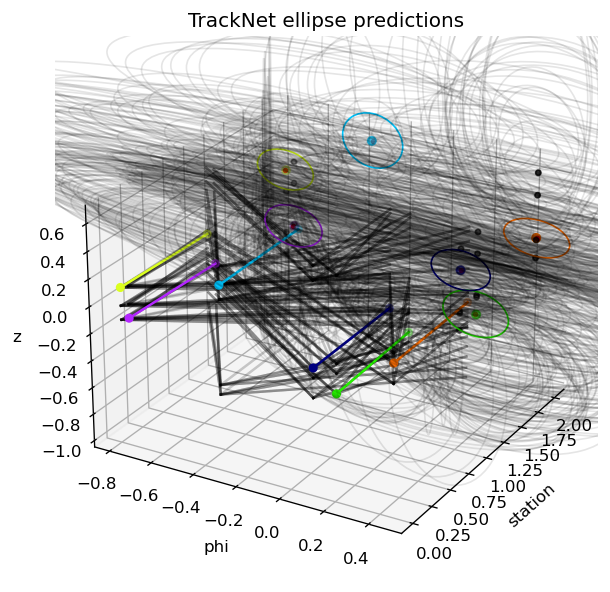

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Ellipse, PathPatch

X_AXIS_NAME = 'station'
Y_AXIS_NAME = 'phi'
Z_AXIS_NAME = 'z'

FAKE_ZORDER = 5
REAL_ZORDER = 20

X_AXIS = ['station_p', 'station_c']
Y_AXIS = ['phi_p', 'phi_c']
Z_AXIS = ['z_p', 'z_p']

def draw_ellipse_on_station(ax, seed, ellipse_tensor, station_to_draw, ellipse_for_fake, col, zorder_):    
    
    ellipse_np = ellipse_tensor
    assert station_to_draw <= ellipse_np.shape[0] and station_to_draw > 0, f"shape={ellipse_np.shape[0]} station_to_draw={station_to_draw}"
    
    ellipse = ellipse_np[station_to_draw - 1]
    z = ellipse[0]
    phi = ellipse[1]
    station = station_to_draw
    if seed.track:
        ax.scatter(station, phi, zs=z, color='r', zorder=zorder_+12, s=5)

    xy = (phi, z)
    
    w = ellipse[3]
    h = ellipse[2]    
    if ellipse_for_fake or seed.track:
        p = Ellipse(xy, w * 2, h * 2, color=col, fill=False, zorder=zorder_)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=station, zdir="x")

def draw_track(ax, seed, colors_tracks, ellipse, ellipse_for_fake, lines_for_fake):
    if not seed.track:
        col = (0.0, 0.0, 0.000, 0.1)
        zorder_ = FAKE_ZORDER
    else:
        col = colors_tracks[seed.track_p]
        zorder_ = REAL_ZORDER

    val_x = seed[X_AXIS].values
    val_y = seed[Y_AXIS].values
    val_z = seed[Z_AXIS].values
    
    if lines_for_fake or seed.track:
        ax.plot(val_x, val_y, zs=val_z, color=col, zorder=zorder_)
    
    if seed.track:
        ax.scatter(val_x, val_y, zs=val_z, color=col, zorder=zorder_)
    
    #draw_ellipse_on_station(ax, seed, ellipse, 1, ellipse_for_fake, col, zorder_)
    draw_ellipse_on_station(ax, seed, ellipse, 2, ellipse_for_fake, col, zorder_)

def visual_predict(seeds, target, pred):
    
    #for p in pred:
    #    print(p)
    #    return
    fig = plt.figure(figsize=(8, 6), dpi=120)
    ax = fig.add_subplot(111, projection='3d')
    # good view
    ax.view_init(25, 30)
    
    # view from the begin
    #ax.view_init(0, 0)
    
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, seeds.track_p.nunique())]
    colors_tracks = { seeds.track_p.unique()[idx]: col for idx, col in enumerate(colors)}
    colors_tracks[-1] = (0.0, 0.0, 0.000, 0.1)
    
    
    for (idx, seed) in seeds.iterrows():
        draw_track(ax, seed, colors_tracks, pred[idx], ellipse_for_fake=True, lines_for_fake=True)    
    
    true_points = target[target.track != -1]
    false_points = target[target.track == -1]
    
    target_colors = [colors_tracks[c] for c in true_points.track.values]

    fake_color = (0.0, 0.0, 0.0, 0.8)
    
    ax.scatter(true_points[[X_AXIS_NAME]].values, true_points[[Y_AXIS_NAME]].values, zs=true_points[[Z_AXIS_NAME]].values, color=target_colors, s=25, zorder=REAL_ZORDER+10)    
    ax.scatter(false_points[[X_AXIS_NAME]].values, false_points[[Y_AXIS_NAME]].values, zs=false_points[[Z_AXIS_NAME]].values, color=fake_color, s=10, zorder=REAL_ZORDER+15)
    
    ax.set_xlabel(X_AXIS_NAME)
    ax.set_ylabel(Y_AXIS_NAME)
    ax.set_zlabel(Z_AXIS_NAME)
    ax.invert_xaxis()
    ax.set_title("TrackNet ellipse predictions")

visual_predict(seeds, target, pred)

In [95]:
seeds

,event,station_p,track_p,index_old_p,r_p,phi_p,z_p,station_c,track_c,index_old_c,r_c,phi_c,z_c,track
0,1,0,11,76,-0.964253,0.101796,-0.112125,1,11,77,0.058737,0.093696,-0.178593,True
1,1,0,11,76,-0.964253,0.101796,-0.112125,1,12,80,0.058736,-0.329928,0.458473,False
2,1,0,11,76,-0.964253,0.101796,-0.112125,1,14,83,0.058736,0.182308,-0.409282,False
3,1,0,11,76,-0.964253,0.101796,-0.112125,1,15,86,0.058736,-0.766054,0.175158,False
4,1,0,11,76,-0.964253,0.101796,-0.112125,1,17,89,0.058737,0.444255,0.102673,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,1,0,-1,33,-0.964253,-0.782457,-0.016784,1,-1,50,0.058736,-0.728744,0.237136,False
617,1,0,-1,33,-0.964253,-0.782457,-0.016784,1,-1,51,0.058736,-0.766054,-0.327937,False
618,1,0,-1,33,-0.964253,-0.782457,-0.016784,1,-1,52,0.058736,-0.766054,-0.251117,False
619,1,0,-1,33,-0.964253,-0.782457,-0.016784,1,-1,53,0.058736,-0.766054,-0.208941,False


In [96]:
target

,event,station,track,index_old,r,phi,z
0,1,2,11,78,0.989770,0.091639,-0.239649
1,1,2,12,81,0.989770,-0.337503,0.592046
2,1,2,14,84,0.989770,0.169338,-0.552340
3,1,2,15,87,0.989770,-0.756867,0.224901
4,1,2,17,90,0.989769,0.437103,0.135287
5,1,2,18,93,0.989770,-0.717420,-0.196025
6,1,2,-1,55,0.989769,0.437103,-0.014750
7,1,2,-1,56,0.989769,0.437103,0.119569
8,1,2,-1,57,0.989769,0.437103,0.453938
9,1,2,-1,58,0.989769,0.437103,0.619693


In [97]:
import faiss

def faiss_seeds_for_class(seeds, target, pred):
    index = faiss.IndexFlatL2(2)
    db = np.ascontiguousarray(target[['z','phi']].values).astype('float32')
    index.add(db)
    
    what_search = np.ascontiguousarray(pred[:,1,:2].astype('float32'))
    d, idx = index.search(what_search, 1)

    return d, idx


In [116]:
def in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h):
    return (np.square(pnts_x - ellipse_x) / np.square(ellipse_dist_w) + np.square(pnts_y - ellipse_y) / np.square(ellipse_dist_h)) <= 1

def filter_by_ellipse(seeds, target, pred, pred_gru):

    dist, idx = faiss_seeds_for_class(seeds, target, pred)
    selected_pnts = target.iloc[idx.T[0]]

    ellipse_x = pred[:,1,0]
    ellipse_y = pred[:,1,1]
    ellipse_dist_w = pred[:,1,2]
    ellipse_dist_h = pred[:,1,3]
    
    pnts_x = selected_pnts[['z']].values.T[0]
    pnts_y = selected_pnts[['phi']].values.T[0]
    
    selected_pnts['in_ellipse'] = in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h)
    
    seeds['index_next'] = selected_pnts.index_old.values
    seeds['in_ellipse'] = selected_pnts.in_ellipse.values
    seeds['z_next'] = selected_pnts.z.values
    seeds['phi_next'] = selected_pnts.phi.values

    seeds.track = np.logical_and(seeds.track.values, (seeds.track_c.values == selected_pnts.track.values))

    return seeds[seeds.in_ellipse == True], pred_gru[seeds.in_ellipse == True]
    

filtered, filtered_gru = filter_by_ellipse(seeds, target, pred, pred_gru)

In [117]:
from torch.nn import functional as F

def final_class_pred(class_model, filtered_gru, filtered, threshold):
    class_pred = F.sigmoid(class_model(torch.tensor(filtered_gru[:, 1, :]).to(DEVICE), torch.tensor(filtered[['z_next', 'phi_next']].values).to(DEVICE)))
    filtered['class_pred_score'] = (class_pred).detach().cpu().numpy()
    filtered['track_pred'] = filtered.class_pred_score > threshold
    return filtered

final = final_class_pred(class_model, filtered_gru, filtered, threshold)

In [118]:
filtered[filtered.track_pred | filtered.track]

,event,station_p,track_p,index_old_p,r_p,phi_p,z_p,station_c,track_c,index_old_c,r_c,phi_c,z_c,track,index_next,in_ellipse,z_next,phi_next,class_pred_score,track_pred
0,1,0,11,76,-0.964253,0.101796,-0.112125,1,11,77,0.058737,0.093696,-0.178593,True,78,True,-0.239649,0.091639,0.597327,True
28,1,0,12,79,-0.964253,-0.320603,0.311956,1,12,80,0.058736,-0.329928,0.458473,True,81,True,0.592046,-0.337503,0.456925,False
56,1,0,14,82,-0.964253,0.205075,-0.255240,1,14,83,0.058736,0.182308,-0.409282,True,84,True,-0.552340,0.169338,0.597327,True
84,1,0,15,85,-0.964253,-0.782457,0.117049,1,15,86,0.058736,-0.766054,0.175158,True,87,True,0.224901,-0.756867,0.597327,True
112,1,0,17,88,-0.964253,0.454569,0.068654,1,17,89,0.058737,0.444255,0.102673,True,90,True,0.135287,0.437103,0.597327,True
140,1,0,18,91,-0.964253,-0.745323,-0.093563,1,18,92,0.058736,-0.728744,-0.146963,True,93,True,-0.196025,-0.717420,0.597327,True
312,1,0,-1,22,-0.964253,0.101796,-0.328753,1,-1,43,0.058737,0.093696,-0.479660,False,64,True,-0.574018,0.091639,0.597327,True
562,1,0,-1,31,-0.964253,-0.745323,0.143480,1,-1,50,0.058736,-0.728744,0.237136,False,71,True,0.304099,-0.717420,0.538107,True


In [ ]:
pred[i]

In [ ]:
seeds[seeds.track]

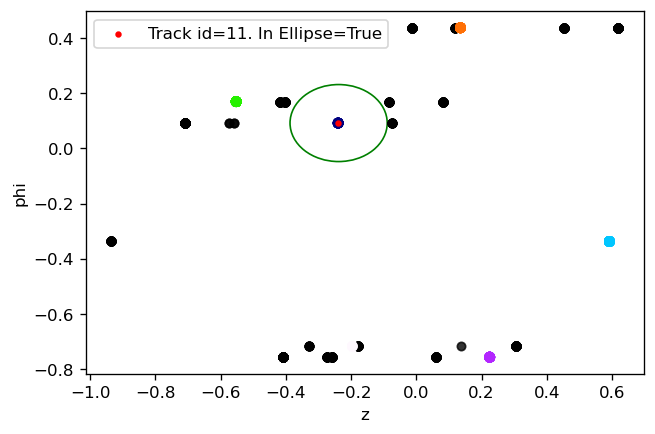

In [121]:
def visualize_preds(point_id, seeds, pred, selected_pnts, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=(6,4), dpi=120)
        ax = fig.add_subplot(111)
    
    ellipse_center_xy = pred[point_id][-1][:2]
    ellipse_wh = pred[point_id][-1][2:]

    pnt_nearest = selected_pnts.iloc[point_id][['z', 'phi']].values
    is_in_ellipse = in_ellipse_check(pnt_nearest[0], ellipse_center_xy[0], ellipse_wh[0], pnt_nearest[1], ellipse_center_xy[1], ellipse_wh[1])
    
    #print(f"Point is in the ellipse: {is_in_ellipse}")
    #print(ellipse_center_xy, ellipse_wh[0], ellipse_wh[1])
    p = Ellipse(ellipse_center_xy, ellipse_wh[0] * 2, ellipse_wh[1] * 2, color='g', fill=False)
    ax.add_patch(p)
    
    track_id = int(selected_pnts.iloc[point_id].track)
    
    ax.scatter(pnt_nearest[0], pnt_nearest[1], color='r', s=8, zorder=20, label=f'Track id={track_id}. In Ellipse={is_in_ellipse}')
    
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, selected_pnts.track.nunique())]
    colors_tracks = { selected_pnts.track.unique()[idx]: col for idx, col in enumerate(colors)}
    colors_tracks[-1] = (0.0, 0.0, 0.000, 0.1)
    
    
    true_points = selected_pnts[selected_pnts.track != -1]
    false_points = selected_pnts[selected_pnts.track == -1]
    
    true_colors = [colors_tracks[c] for c in true_points.track.values]

    fake_color = (0.0, 0.0, 0.0, 0.8)
    
    ax.scatter(true_points[['z']].values, true_points[['phi']].values, s=30, zorder=10, color=true_colors)
    ax.scatter(false_points[['z']].values, false_points[['phi']].values, s=25, zorder=5, color=fake_color)
    
    #selected_pnts = selected_pnts[selected_pnts.track != track_id]
    #colors = [col]
    #ax.scatter(selected_pnts[['z']].values, selected_pnts[['phi']].values, s=30, zorder=5)
    
    ax.set_xlabel('z')
    ax.set_ylabel('phi')
    ax.autoscale_view()
    ax.legend()
    #plt.show()

dist, idx = faiss_seeds_for_class(seeds, target, pred)
selected_pnts = target.iloc[idx.T[0]]
visualize_preds(0, seeds, pred, selected_pnts)

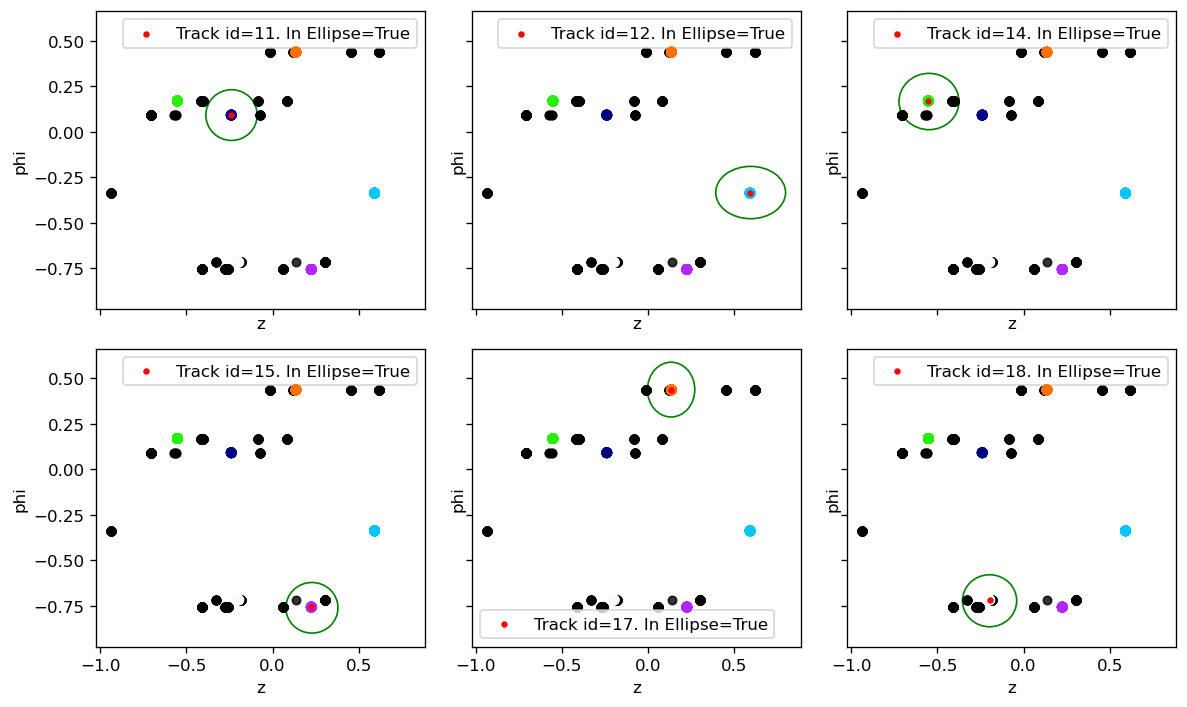

In [123]:
def visualize_real_preds(idx, seeds, pred, selected_pnts):
    count_tracks = len(seeds[seeds.track])
    if count_tracks == 0:
        print("no tracks")
        return
    columns = 3
    
    fig = plt.figure(figsize=(10,6), dpi=120)
    axes = fig.subplots(nrows=count_tracks // columns, ncols=columns, sharex='all', sharey='all')
    
    row = 0
    col = 0
    for seed_id, seed in seeds[seeds.track].iterrows():        
        visualize_preds(seed_id, seeds, pred, selected_pnts, axes[row][col])
        col+=1
        if col == columns:
            col = 0
            row+=1
    fig.tight_layout()
        

visualize_real_preds(idx, seeds, pred, selected_pnts)

In [ ]:
import faiss


what_search = np.ascontiguousarray(target[['z','phi']].values[:3].astype('float32'))

dist, idx = index.search(what_search, 3)
print(f"dist = {dist}")
print(f"idx = {idx}")
print(f"db = {db}")
print(f"what_search = {what_search}")

In [ ]:
import faiss
index = faiss.IndexFlatL2(2)
db = np.ascontiguousarray(target[['x','y']].values).astype('float32')
index.add(db)

what_search = np.ascontiguousarray(target[['x','y']].values[:3].astype('float32')) + 10

dist, idx = index.search(what_search, 3)
print(f"dist = {dist}")
print(f"idx = {idx}")
print(f"db = {db}")
print(f"what_search = {what_search}")

In [ ]:
target[['x','y']].values[:3]

In [ ]:
np.ascontiguousarray(target[['x','y']].values[:3].astype('float32'))